# Noise2Void - 2D Example for BSD68 Data

The data used in this notebook is the same as presented in the paper.

In [2]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Training Data Preparation

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/BSD68_reproducibility.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [4]:
X = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following lines.
# X = np.round(np.clip(X, 0, 255.))
# X_val = np.round(np.clip(X_val, 0, 255.))

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(3168, 180, 180, 1)
(4, 180, 180, 1)


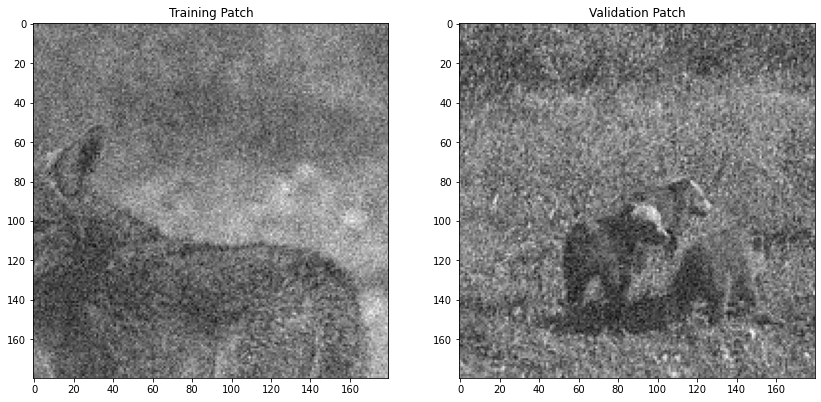

In [5]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch');

# Configure

In [7]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=400, train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=2,
                   single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['110.72957232412905'],
 'stds': ['63.656060106500874'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 2,
 'single_net_per_channel': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [9]:
# a name used to identify the model
model_name = 'BSD68_reproducability_5x5'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

/home/ben/Documents/University Of Southampton/COMP6248 Deep Learning/Coursework/Methods/N2V/n2v/models/n2v_standard.py:415: UserWarning: output path for model already exists, files may be overwritten: /home/ben/Documents/University Of Southampton/COMP6248 Deep Learning/Coursework/Methods/N2V/examples/2D/denoising2D_BSD68/models/BSD68_reproducability_5x5
  warnings.warn(
2022-05-13 00:10:03.883112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 00:10:03.964193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 00:10:03.964451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA n

# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [10]:
# We are ready to start training now.
history = model.train(X, X_val)

/home/ben/Documents/University Of Southampton/COMP6248 Deep Learning/Coursework/Methods/N2V/n2v/models/n2v_standard.py:194: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100 * frac_val))


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 295.42it/s]


Epoch 1/200


2022-05-13 00:10:13.176133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-13 00:10:14.583098: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-13 00:10:14.584790: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-05-13 00:10:14.584814: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-05-13 00:10:14.584910: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

400/400 [==============================] - 90s 207ms/step - loss: 0.2298 - val_loss: 0.2609 - lr: 4.0000e-04
Epoch 2/200
400/400 [==============================] - 83s 206ms/step - loss: 0.2077 - val_loss: 0.1963 - lr: 4.0000e-04
Epoch 3/200
400/400 [==============================] - 83s 207ms/step - loss: 0.2050 - val_loss: 0.1890 - lr: 4.0000e-04
Epoch 4/200
400/400 [==============================] - 80s 200ms/step - loss: 0.2033 - val_loss: 0.1842 - lr: 4.0000e-04
Epoch 5/200
400/400 [==============================] - 79s 198ms/step - loss: 0.2016 - val_loss: 0.1863 - lr: 4.0000e-04
Epoch 6/200
400/400 [==============================] - 79s 197ms/step - loss: 0.2009 - val_loss: 0.1879 - lr: 4.0000e-04
Epoch 7/200
400/400 [==============================] - 78s 196ms/step - loss: 0.2013 - val_loss: 0.1861 - lr: 4.0000e-04
Epoch 8/200
400/400 [==============================] - 79s 197ms/step - loss: 0.1998 - val_loss: 0.1948 - lr: 4.0000e-04
Epoch 9/200
400/400 [=======================

### After training, lets plot training and validation loss.

['loss', 'lr', 'val_loss']


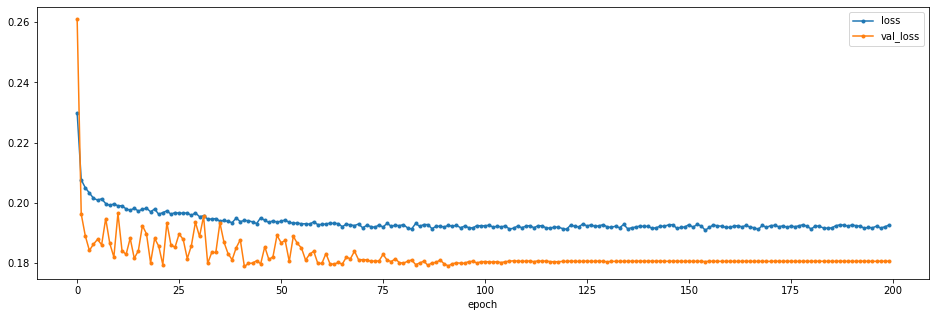

In [11]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# Compute PSNR to GT

In [12]:
model.export_TF(name='Noise2Void - 2D BW Example',
                description='This is the 2D Noise2Void example trained on RGB data in python.',
                authors=["Tim-Oliver Buchholz", "Alexander Krull", "Florian Jug"],
                test_img=X_val[0], axes='YXC',
                patch_shape=(64,64))

The input image is of type float64 and will be casted to float32 for prediction.
Instructions for updating:
Colocations handled automatically by placer.


2022-05-13 08:34:41.883436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 08:34:41.883693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 08:34:41.883896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 08:34:41.884146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 08:34:41.884361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


/home/ben/anaconda3/envs/N2V/lib/python3.9/site-packages/csbdeep/utils/tf.py:177: UserWarning: 
***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183

  warnings.warn(\


INFO:tensorflow:SavedModel written to: /tmp/tmpc4bqefda/model/saved_model.pb

Model exported in BioImage ModelZoo format:
/home/ben/Documents/University Of Southampton/COMP6248 Deep Learning/Coursework/Methods/N2V/examples/2D/denoising2D_BSD68/models/BSD68_reproducability_5x5/export.bioimage.io.zip


In [9]:
groundtruth_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)

In [10]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following line.
# test_data = np.round(np.clip(test_data, 0, 255.))

In [11]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [12]:
# Weights corresponding to the smallest validation loss
# Smallest validation loss does not necessarily correspond to best performance, 
# because the loss is computed to noisy target pixels.
model.load_weights('weights_best.h5')

In [13]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=False);
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [14]:
print("PSNR (without test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (without test-time augmentation): 27.81


In [15]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=True);
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [16]:
print("PSNR (with test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (with test-time augmentation): 27.88


In [17]:
# The weights of the converged network. 
model.load_weights('weights_last.h5')

In [18]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=False)
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [19]:
print("PSNR (without test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (without test-time augmentation): 27.77


In [20]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=True)
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [21]:
print("PSNR (with test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (with test-time augmentation): 27.84
